# Neural Networks for Fraud Detection
## From Perceptron to Multi-Layer Networks

This notebook implements neural networks of increasing complexity for fraud detection, building upon our understanding of logistic regression. We'll follow a structured journey from simple perceptrons to multi-layer neural networks, with a focus on fraud detection applications.

## Table of Contents
1. [Setup and Data Preparation](#1-setup-and-data-preparation)
2. [The Perceptron for Fraud Detection](#2-the-perceptron-for-fraud-detection)
3. [Decision Boundary Visualization](#3-decision-boundary-visualization)
4. [Multi-Layer Perceptron with Keras](#4-multi-layer-perceptron-with-keras)
5. [Training and Optimization](#5-training-and-optimization)
6. [Model Evaluation for Fraud](#6-model-evaluation-for-fraud)
7. [Balancing Complexity and Interpretability](#7-balancing-complexity-and-interpretability)
8. [Performance Comparison](#8-performance-comparison)
9. [Conclusion and Future Directions](#9-conclusion-and-future-directions)

## 0. Configuring Google Colab for GPU Use

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [5]:
file_id = '1ETuMsNV5YTu2VWxP68695FDsrQdfMQDB'
destination = '/tmp/fraud_train.csv'
download_file_from_google_drive(file_id, destination)

In [6]:
file_id = '10r2FX6dG-NXVTyY6vsziEyrvSSdREJej'
destination = '/tmp/fraud_train_small.csv'
download_file_from_google_drive(file_id, destination)

In [7]:
file_id = '10xzULwOF1KkbuZSR4XELSQQhac5vYhO2'
destination = '/tmp/fraud_test.csv'
download_file_from_google_drive(file_id, destination)

## 1. Setup and Data Preparation

Let's first set up our environment and prepare the fraud dataset. We'll reuse the preprocessing steps from our logistic regression implementation to ensure fair comparison between models.

In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams.update({'font.size': 14, 'axes.labelsize': 14, 'xtick.labelsize': 12,
                     'ytick.labelsize': 12, 'legend.fontsize': 12})

# Check for GPU availability (for Keras)
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", len(tf.config.list_physical_devices('GPU')) > 0)

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.18.0
GPU Available:  True


In [8]:
# Load the fraud dataset
df = pd.read_csv('/tmp/fraud_train.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (100000, 32)


,Unnamed: 0,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,...,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
0,409919,0,0.5,0.533645,-1,47,20,0.010426,-0.775947,AC,...,-1,0,1500.0,0,INTERNET,30.650408,other,0,1,3
1,679596,0,0.6,0.762213,198,8,20,0.020051,10.628024,AA,...,28,0,500.0,0,INTERNET,2.045171,other,1,1,5
2,579377,0,0.9,0.386071,60,12,20,7.009744,51.695466,AA,...,29,0,1000.0,0,INTERNET,11.071376,linux,1,1,4
3,851406,0,0.6,0.311304,-1,221,40,0.012369,-1.236389,AB,...,11,0,1500.0,0,INTERNET,10.796589,linux,1,1,6
4,519975,0,0.1,0.824045,86,6,20,0.039485,-0.659062,AC,...,-1,0,200.0,0,INTERNET,6.790446,linux,1,1,3


### Data Preprocessing

We'll apply the same preprocessing steps used for logistic regression to ensure a fair comparison between models.

In [9]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values,
                           'Percentage': missing_percent})
print("Missing values summary:")
print(missing_df[missing_df['Missing Values'] > 0])

# Handle missing values (creating flags and imputing)
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('fraud_bool')  # Remove target variable

for feature in numeric_features:
    if df[feature].isnull().sum() > 0:
        df[f'{feature}_missing'] = df[feature].isnull().astype(int)
        df[feature].fillna(df[feature].median(), inplace=True)

# Encode categorical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical features: {categorical_features}")
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Prepare features and target
X = df_encoded.drop('fraud_bool', axis=1)
y = df_encoded['fraud_bool']

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")
print(f"Fraud percentage in training set: {y_train.mean() * 100:.2f}%")

Missing values summary:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []
Categorical features: ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
Training set shape: (75000, 47)
Testing set shape: (25000, 47)
Fraud percentage in training set: 1.06%


## 2. The Perceptron for Fraud Detection

The perceptron is the simplest form of a neural network - a single artificial neuron. It takes weighted inputs, applies a step function, and produces a binary output. Despite its simplicity, it helps us understand the foundation of neural networks.

### Theoretical Background

The perceptron algorithm works as follows:
1. Initialize weights randomly
2. For each input sample:
   - Calculate the weighted sum: $z = w_0 + w_1x_1 + w_2x_2 + ... + w_nx_n$
   - Apply step function: $output = 1$ if $z > 0$ else $0$
   - Update weights if prediction is incorrect: $w_i = w_i + \alpha(y - \hat{y})x_i$
3. Repeat until convergence or maximum iterations

Unlike logistic regression which outputs probabilities using the sigmoid function, the perceptron produces binary outputs using a step function.

Perceptron Performance:
Accuracy: 0.9812
Precision: 0.0714
Recall: 0.0642
F1 Score: 0.0676


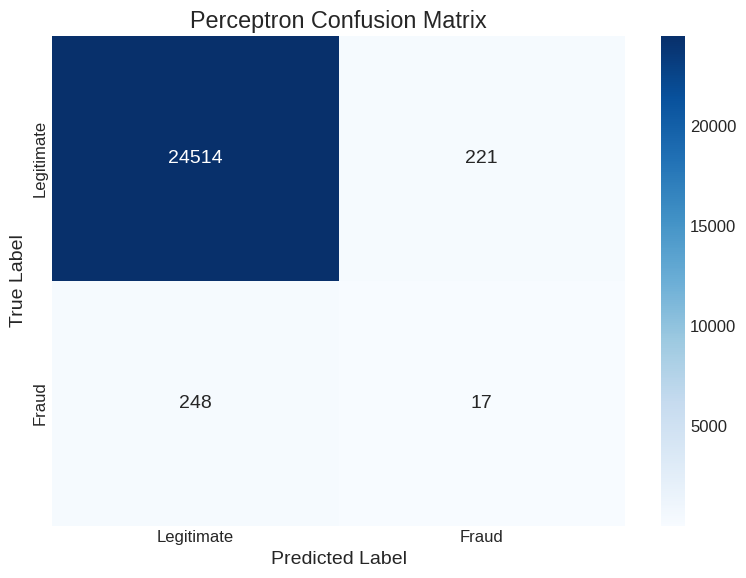

In [10]:
# Implement a perceptron for fraud detection
perceptron = Perceptron(max_iter=1000, random_state=42, alpha=0.0001)
perceptron.fit(X_train_scaled, y_train)

# Make predictions
y_pred_perceptron = perceptron.predict(X_test_scaled)

# Display basic metrics
accuracy = accuracy_score(y_test, y_pred_perceptron)
precision = precision_score(y_test, y_pred_perceptron)
recall = recall_score(y_test, y_pred_perceptron)
f1 = f1_score(y_test, y_pred_perceptron)

print("Perceptron Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_perceptron)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Perceptron Confusion Matrix')
plt.tight_layout()
plt.show()

### Understanding the Perceptron's Limitations

The perceptron has several key limitations for fraud detection:

1. **Binary output**: The perceptron only outputs 0 or 1, not probabilities. This makes it difficult to adjust thresholds for different business needs.

2. **Linear decision boundary**: Like logistic regression, the perceptron can only create linear decision boundaries, limiting its ability to capture complex fraud patterns.

3. **No built-in regularization**: The standard perceptron lacks regularization mechanisms, making it prone to overfitting.

4. **Cannot solve XOR problems**: The perceptron cannot learn non-linearly separable patterns like XOR, which are common in fraud detection (e.g., a transaction might be suspicious if amount is very high OR very low, but not in the middle).

Let's examine the perceptron's decision weights to see what it learned:

Top 10 most important features according to perceptron:
                      Feature     Weight  Abs_Weight
41          housing_status_BG -67.552352   67.552352
29            payment_type_AE -58.715460   58.715460
35       employment_status_CG -43.018982   43.018982
40          housing_status_BF -23.716330   23.716330
21            foreign_request  -8.858834    8.858834
2       name_email_similarity  -7.770954    7.770954
3   prev_address_months_count  -7.550241    7.550241
19            has_other_cards  -7.184887    7.184887
42             source_TELEAPP  -7.109937    7.109937
24  device_distinct_emails_8w   6.569570    6.569570


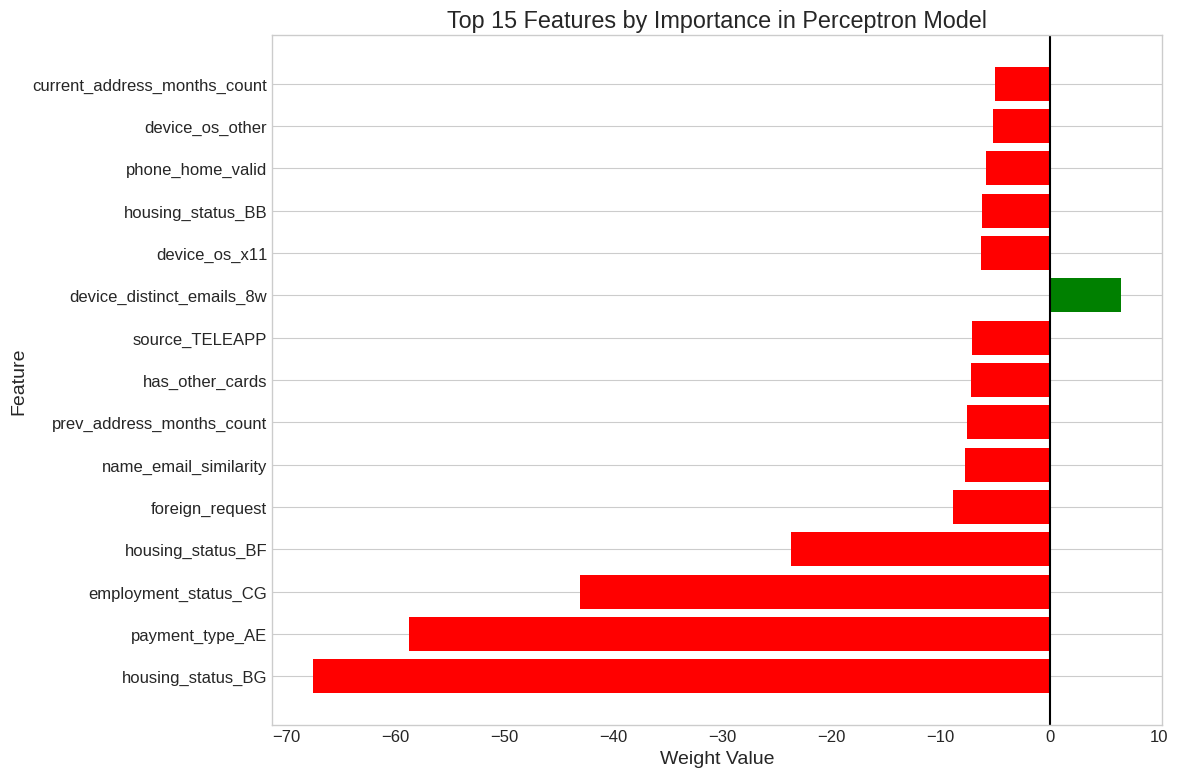

In [11]:
# Examine perceptron weights
perceptron_weights = pd.DataFrame({
    'Feature': X_train.columns,
    'Weight': perceptron.coef_[0]
})

# Sort by absolute weight value
perceptron_weights['Abs_Weight'] = abs(perceptron_weights['Weight'])
perceptron_weights_sorted = perceptron_weights.sort_values('Abs_Weight', ascending=False)

# Display top weights
print("Top 10 most important features according to perceptron:")
print(perceptron_weights_sorted.head(10))

# Visualize top weights
plt.figure(figsize=(12, 8))
top_weights = perceptron_weights_sorted.head(15)
colors = ['red' if x < 0 else 'green' for x in top_weights['Weight']]
plt.barh(top_weights['Feature'], top_weights['Weight'], color=colors)
plt.xlabel('Weight Value')
plt.ylabel('Feature')
plt.title('Top 15 Features by Importance in Perceptron Model')
plt.axvline(x=0, color='black', linestyle='-')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

## 3. Decision Boundary Visualization

To better understand the differences between logistic regression and the perceptron, let's visualize their decision boundaries on a simplified 2D projection of our data. This will help illustrate the limitations of linear models for complex fraud patterns.

We'll use Principal Component Analysis (PCA) to reduce our dataset to 2 dimensions while preserving as much variance as possible.

Explained variance ratio: [0.0826582  0.05022697]
Total variance explained: 0.13


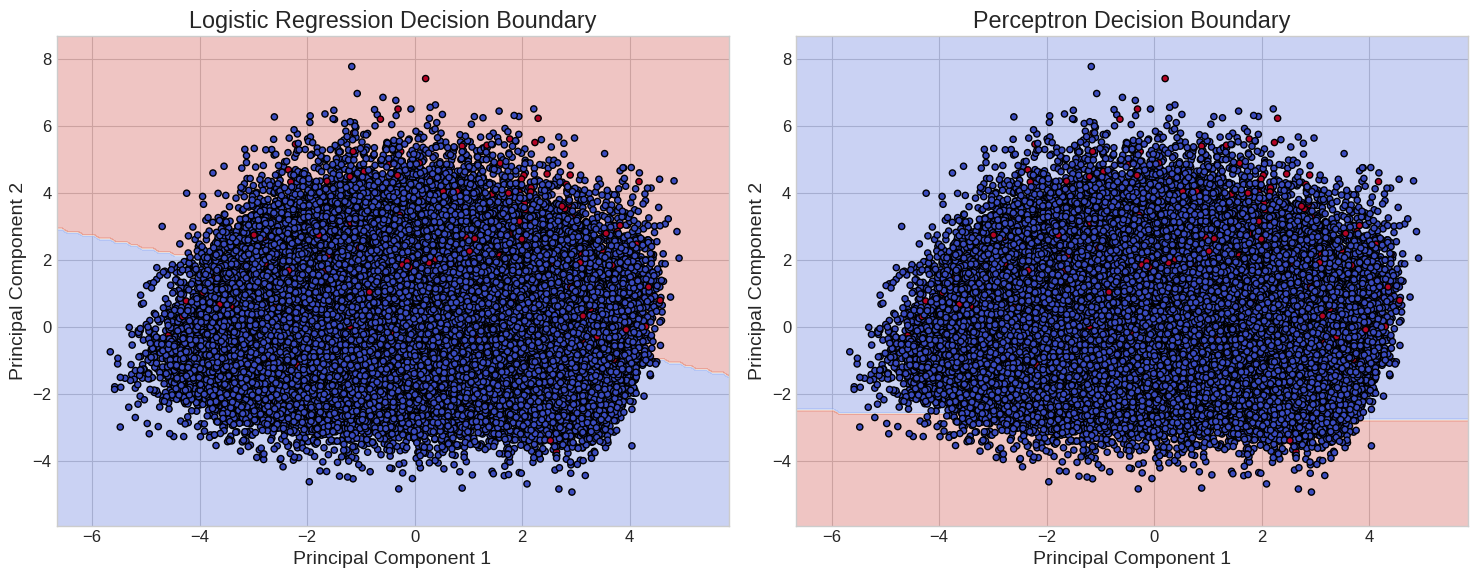

In [12]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec

# Create a 2D projection of our data using PCA
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_scaled)
X_test_2d = pca.transform(X_test_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2f}")

# Train both models on the 2D data
# Logistic Regression
fraud_ratio = y_train.mean()
class_weights = {0: fraud_ratio, 1: 1-fraud_ratio}
logistic_2d = LogisticRegression(class_weight=class_weights, random_state=42).fit(X_train_2d, y_train)

# Perceptron
perceptron_2d = Perceptron(max_iter=1000, random_state=42).fit(X_train_2d, y_train)

# Create a mesh grid for visualization
def plot_decision_boundary(X, y, models, model_names):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    f, axarr = plt.subplots(1, len(models), figsize=(15, 6))

    for idx, (model, name) in enumerate(zip(models, model_names)):
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        axarr[idx].contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
        scatter = axarr[idx].scatter(X[:, 0], X[:, 1], c=y,
                           s=20, edgecolor='k', cmap='coolwarm')
        axarr[idx].set_title(f'{name} Decision Boundary')
        axarr[idx].set_xlabel('Principal Component 1')
        axarr[idx].set_ylabel('Principal Component 2')

    plt.tight_layout()
    plt.show()

# Plot decision boundaries
plot_decision_boundary(X_train_2d, y_train,
                     [logistic_2d, perceptron_2d],
                     ['Logistic Regression', 'Perceptron'])

### Analyzing Decision Boundaries

The visualization above illustrates several important points:

1. **Linear Limitations**: Both logistic regression and the perceptron create linear decision boundaries, which may not capture the complex patterns in fraud data.

2. **Subtle Differences**: While mathematically similar, logistic regression and the perceptron can produce slightly different boundaries due to their different training objectives (log loss vs. hinge loss).

3. **Dimensionality Reduction Trade-off**: By reducing to 2D for visualization, we've lost information (as shown by the explained variance ratio). Real fraud patterns likely exist in higher dimensions that cannot be visualized directly.

These limitations motivate the need for more flexible models like multi-layer neural networks that can create non-linear decision boundaries.

## 4. Multi-Layer Perceptron with Keras

Now we'll implement a Multi-Layer Perceptron (MLP) using Keras. This will allow us to create non-linear decision boundaries and capture more complex fraud patterns.

### What is a Multi-Layer Perceptron?

A Multi-Layer Perceptron (MLP) is a feedforward neural network with one or more hidden layers between the input and output layers. The key improvements over a single perceptron include:

1. **Non-linear activation functions**: Hidden layers use activation functions like ReLU or tanh to introduce non-linearity.

2. **Multiple layers**: Each layer can learn different representations of the data, with deeper layers capturing more abstract concepts.

3. **Backpropagation**: MLPs are trained using backpropagation, which efficiently calculates gradients for all weights in the network.

### Designing a Network Architecture for Fraud

For fraud detection, we need to consider several factors when designing our network:

1. **Input layer**: One node per feature (same as our scaled feature count)

2. **Hidden layers**: Usually 1-3 hidden layers is sufficient for tabular data like our fraud dataset

3. **Hidden layer size**: Common heuristics include:
   - Mean of input and output size
   - 2/3 the size of the input layer
   - Power of 2 (e.g., 32, 64, 128) for computational efficiency

4. **Output layer**: Single node with sigmoid activation for binary classification

5. **Regularization**: Dropout and/or L2 regularization to prevent overfitting, especially important with imbalanced data

Let's implement this model with Keras:

In [16]:
# Function to create MLP model
def create_mlp_model(input_dim, hidden_layers=[64, 32], dropout_rate=0.3, l2_strength=0.01):
    """Create a multi-layer perceptron model for fraud detection"""
    model = keras.Sequential()

    # Input layer
    model.add(layers.Input(shape=(input_dim,)))

    # Hidden layers
    for units in hidden_layers:
        model.add(layers.Dense(
            units=units,
            activation='relu',
            kernel_regularizer=regularizers.l2(l2_strength)
        ))
        model.add(layers.Dropout(dropout_rate))

    # Output layer (sigmoid for binary classification)
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Create model
input_dim = X_train_scaled.shape[1]
mlp_model = create_mlp_model(input_dim)

# Compile model with class weights (for imbalanced data)
# Calculate class weights (inverse of frequency)
fraud_ratio = y_train.mean()
class_weight = {0: fraud_ratio, 1: 1-fraud_ratio}

mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC()
    ]
)

# Display model summary
mlp_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,185 (20.25 KB)

 Trainable params: 5,185 (20.25 KB)

 Non-trainable params: 0 (0.00 B)

### Understanding the MLP Architecture

Let's analyze the MLP architecture we've created:

1. **Input Layer**: Takes our scaled features as input

2. **Hidden Layers**: Two hidden layers with 64 and 32 neurons respectively, using ReLU activation for non-linearity

3. **Regularization**:
   - Dropout (30%) to prevent overfitting by randomly disabling neurons during training
   - L2 regularization (weight decay) to prevent large weights

4. **Output Layer**: Single neuron with sigmoid activation, outputting a probability between 0 and 1

5. **Loss Function**: Binary cross-entropy, appropriate for binary classification problems

6. **Optimizer**: Adam, which adapts the learning rate and includes momentum

7. **Class Weights**: Handling class imbalance by weighting the minority class (fraud) more heavily

This architecture balances complexity (ability to learn non-linear patterns) with regularization (to prevent overfitting), making it suitable for fraud detection.

## 5. Training and Optimization

Now we'll train our MLP model and implement several techniques to optimize its performance, including:

1. **Early stopping**: To prevent overfitting by monitoring validation loss
2. **Learning rate scheduling**: To adjust the learning rate during training
3. **Validation set**: To monitor performance on unseen data during training

These techniques are particularly important for fraud detection, where overfitting to the training data can lead to poor generalization to new fraud patterns.

In [19]:
# Create a validation set from the training data
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Set up callbacks
cllbcks = [
    # Early stopping to prevent overfitting
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    # Learning rate reduction when plateau is reached
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001
    ),
    # TensorBoard for visualization (optional)
    # callbacks.TensorBoard(log_dir='./logs')
]

# Train the model
history = mlp_model.fit(
    X_train_final, y_train_final,
    epochs=10,  # We'll use early stopping to determine actual epochs
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    callbacks=cllbcks,
    verbose=1
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.4888 - auc_1: 0.5079 - loss: 0.1597 - precision_1: 0.0107 - recall_1: 0.5242 - val_accuracy: 0.9894 - val_auc_1: 0.5000 - val_loss: 0.6868 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.6076 - auc_1: 0.4722 - loss: 0.0144 - precision_1: 0.0091 - recall_1: 0.3585 - val_accuracy: 0.9894 - val_auc_1: 0.5000 - val_loss: 0.6902 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5409 - auc_1: 0.5059 - loss: 0.0144 - precision_1: 0.0108 - recall_1: 0.4648 - val_accuracy: 0.9894 - val_auc_1: 0.5000 - val_loss: 0.6848 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5949 - auc_1: 0.4845 - loss: 0.0144 - precision_1: 0.0098 - recall

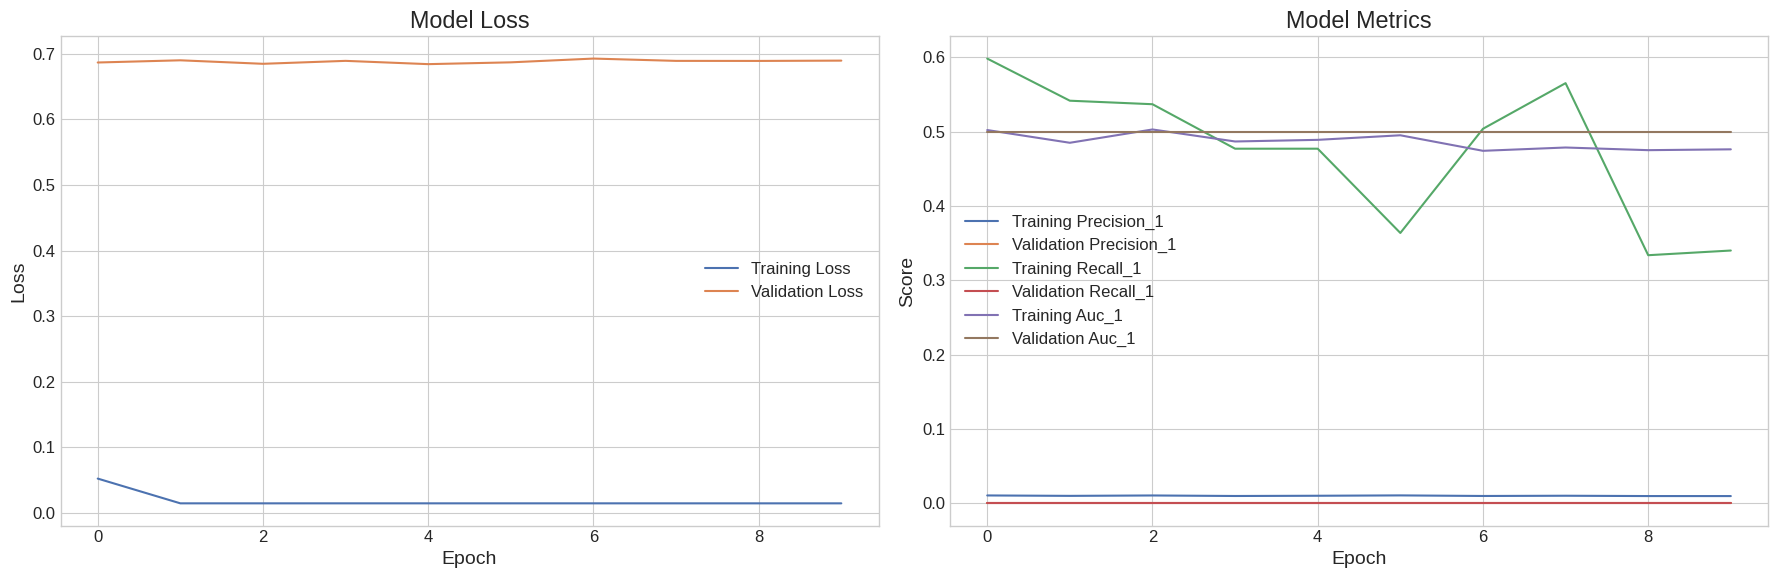

In [24]:
# Visualize training history
def plot_training_history(history):
    """Plot training & validation loss and metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot metrics
    metrics = ['precision_1', 'recall_1', 'auc_1']
    for metric in metrics:
        ax2.plot(history.history[metric], label=f'Training {metric.capitalize()}')
        ax2.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')

    ax2.set_title('Model Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

### Training Analysis

The training plots reveal important insights about our model's learning process:

1. **Convergence**: The loss curves show whether the model converged to a stable solution

2. **Overfitting**: The gap between training and validation loss indicates potential overfitting

3. **Metric Trajectory**: The precision, recall, and AUC curves show how the model's fraud detection capabilities improved during training

4. **Early Stopping Effect**: We can see where early stopping prevented overfitting by stopping training when validation loss stopped improving

For fraud detection, it's particularly important to monitor metrics like precision and recall during training, as accuracy alone can be misleading with imbalanced data.

## 6. Model Evaluation for Fraud

Now, let's thoroughly evaluate our MLP model on the test dataset. For fraud detection, we need to consider performance metrics beyond accuracy, focusing on precision, recall, and business impact metrics.

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MLP Model Performance:
Accuracy: 0.9894
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.6672
Average Precision: 0.0240


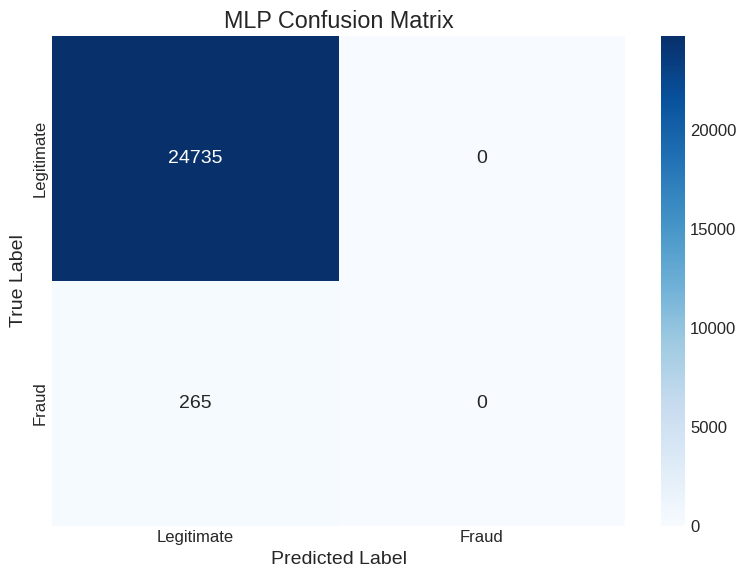

In [25]:
# Get predictions on test set
y_pred_proba_mlp = mlp_model.predict(X_test_scaled).flatten()
y_pred_mlp = (y_pred_proba_mlp >= 0.5).astype(int)

# Basic classification metrics
accuracy = accuracy_score(y_test, y_pred_mlp)
precision = precision_score(y_test, y_pred_mlp)
recall = recall_score(y_test, y_pred_mlp)
f1 = f1_score(y_test, y_pred_mlp)
roc_auc = roc_auc_score(y_test, y_pred_proba_mlp)
avg_precision = average_precision_score(y_test, y_pred_proba_mlp)

print("MLP Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('MLP Confusion Matrix')
plt.tight_layout()
plt.show()

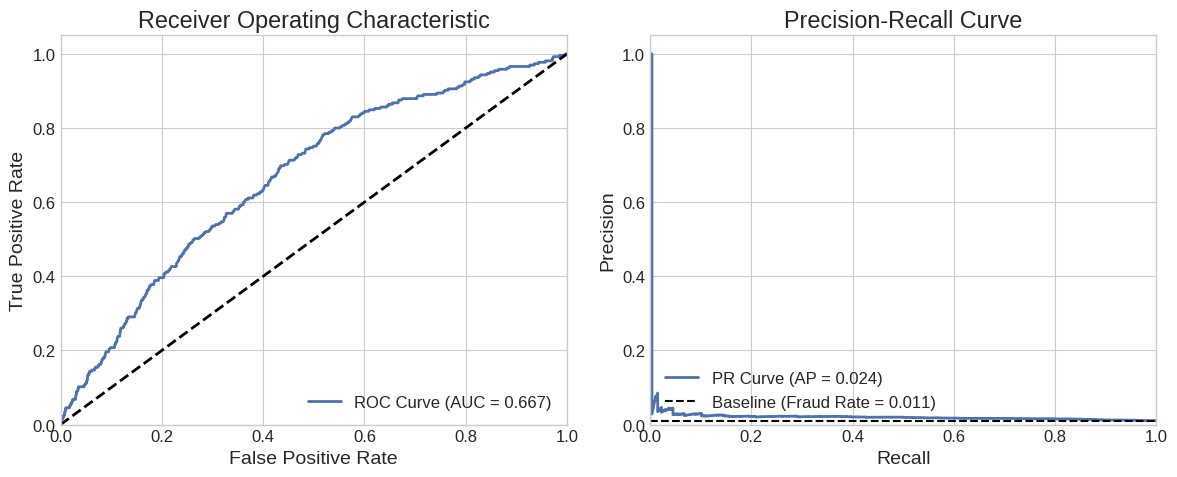

In [26]:
# ROC and PR curves
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_mlp)
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_mlp)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, lw=2,
         label=f'PR Curve (AP = {avg_precision:.3f})')
plt.axhline(y=y_test.mean(), color='k', linestyle='--',
            label=f'Baseline (Fraud Rate = {y_test.mean():.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

### Threshold Optimization for Business Impact

For fraud detection, selecting the optimal threshold is a business decision that balances false positives and false negatives. Let's implement a threshold optimization approach based on business costs:

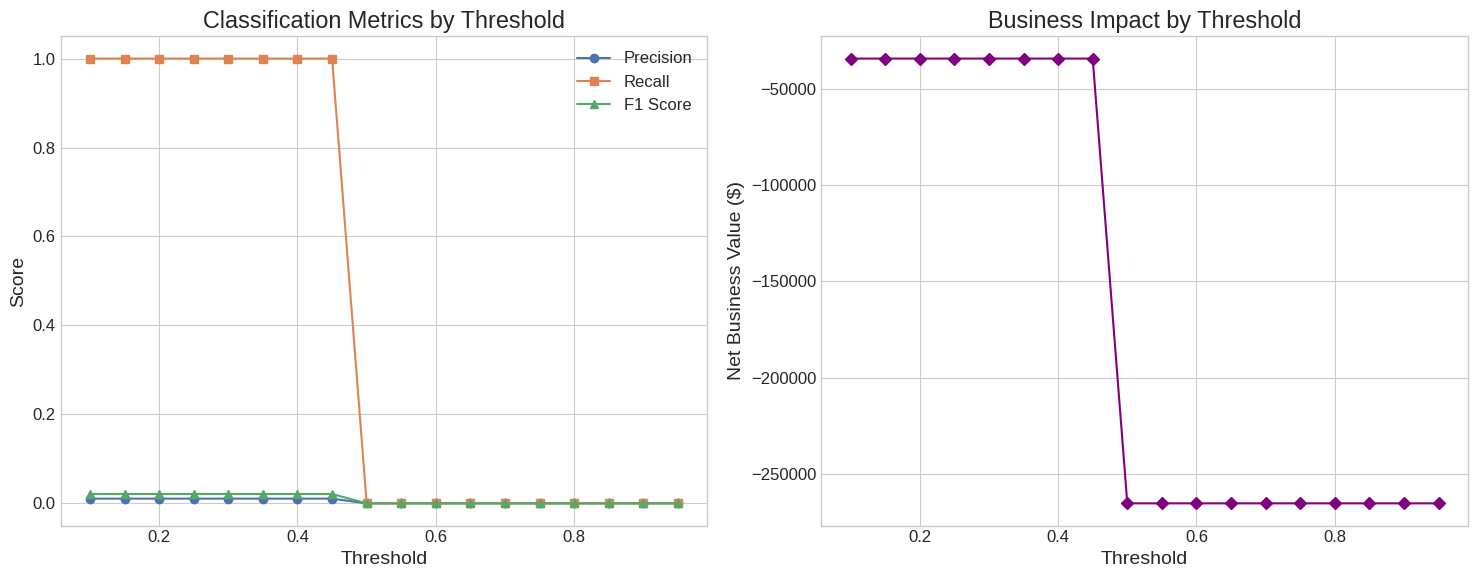

Optimal Threshold: 0.10
At this threshold:
  Precision: 0.0106
  Recall: 1.0000
  F1 Score: 0.0210
  Net Business Value: $-34470.00


In [27]:
# Threshold optimization with business impact
thresholds = np.arange(0.1, 1.0, 0.05)
threshold_metrics = []

for threshold in thresholds:
    y_pred_custom = (y_pred_proba_mlp >= threshold).astype(int)

    # Calculate metrics
    precision_custom = precision_score(y_test, y_pred_custom)
    recall_custom = recall_score(y_test, y_pred_custom)
    f1_custom = f1_score(y_test, y_pred_custom)

    # Business metrics (simplified)
    # Assume:
    # - Each fraudulent transaction costs $1000 on average
    # - Each manual review costs $10
    # - Each false positive causes $2 in customer friction

    true_positives = ((y_pred_custom == 1) & (y_test == 1)).sum()
    false_positives = ((y_pred_custom == 1) & (y_test == 0)).sum()
    false_negatives = ((y_pred_custom == 0) & (y_test == 1)).sum()

    fraud_savings = true_positives * 1000
    review_cost = (true_positives + false_positives) * 10
    friction_cost = false_positives * 2
    missed_fraud_cost = false_negatives * 1000

    net_value = fraud_savings - review_cost - friction_cost - missed_fraud_cost

    threshold_metrics.append({
        'Threshold': threshold,
        'Precision': precision_custom,
        'Recall': recall_custom,
        'F1': f1_custom,
        'TP': true_positives,
        'FP': false_positives,
        'FN': false_negatives,
        'Net Value': net_value
    })

threshold_df = pd.DataFrame(threshold_metrics)

# Plot metrics across thresholds
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(threshold_df['Threshold'], threshold_df['Precision'], marker='o', label='Precision')
plt.plot(threshold_df['Threshold'], threshold_df['Recall'], marker='s', label='Recall')
plt.plot(threshold_df['Threshold'], threshold_df['F1'], marker='^', label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Classification Metrics by Threshold')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(threshold_df['Threshold'], threshold_df['Net Value'], marker='D', color='purple')
plt.xlabel('Threshold')
plt.ylabel('Net Business Value ($)')
plt.title('Business Impact by Threshold')
plt.grid(True)

plt.tight_layout()
plt.show()

# Find optimal threshold based on business value
optimal_threshold_idx = threshold_df['Net Value'].idxmax()
optimal_threshold = threshold_df.loc[optimal_threshold_idx, 'Threshold']
optimal_metrics = threshold_df.loc[optimal_threshold_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"At this threshold:")
print(f"  Precision: {optimal_metrics['Precision']:.4f}")
print(f"  Recall: {optimal_metrics['Recall']:.4f}")
print(f"  F1 Score: {optimal_metrics['F1']:.4f}")
print(f"  Net Business Value: ${optimal_metrics['Net Value']:.2f}")

## 7. Balancing Complexity and Interpretability

One of the key challenges with neural networks for fraud detection is the trade-off between model complexity (which can improve performance) and interpretability (which is crucial for business and regulatory requirements).

Let's explore methods to help interpret our MLP model:

In [28]:
# Partial Dependence Plots (PDPs)
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.neural_network import MLPClassifier

# First we need to train a scikit-learn MLPClassifier (since Keras models aren't compatible with PDPs)
sklearn_mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.01,  # L2 regularization
    batch_size=32,
    max_iter=100,
    random_state=42
)

# Train the model
sklearn_mlp.fit(X_train_scaled, y_train)

# Find most important features from our previous analysis
# In a real scenario, we'd have identified these from feature importance
important_features = [0, 1, 2, 3, 4]  # Example indices of important features

# Create PDPs for important features
fig, ax = plt.subplots(figsize=(12, 8))
plot_partial_dependence(
    sklearn_mlp, X_train_scaled, important_features,
    feature_names=X_train.columns,
    n_cols=3,
    ax=ax
)
plt.suptitle('Partial Dependence Plots for Top Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (/usr/local/lib/python3.11/dist-packages/sklearn/inspection/__init__.py)

### SHAP Values for Local Interpretability

While Partial Dependence Plots help understand the global behavior of the model, SHAP (SHapley Additive exPlanations) values can provide local interpretability for individual predictions. This is particularly valuable in fraud detection, where we may need to explain why a specific transaction was flagged as fraudulent.

In [ ]:
# Install shap if not already installed
# !pip install shap

import shap

# Create a Keras model explainer
# We'll use a smaller sample for computational efficiency
background = X_train_scaled[:100]  # Background dataset for the explainer
test_sample = X_test_scaled[:10]   # Sample of test instances to explain

# Create explainer
explainer = shap.KernelExplainer(mlp_model.predict, background)

# Calculate SHAP values
shap_values = explainer.shap_values(test_sample)

# Visualize SHAP values
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, test_sample, feature_names=X_train.columns)
plt.title('SHAP Values for Neural Network Model')
plt.tight_layout()
plt.show()

# Force plot for a single prediction (most confident fraud prediction)
y_pred_sample = mlp_model.predict(test_sample).flatten()
most_confident_idx = np.argmax(y_pred_sample)

plt.figure(figsize=(12, 3))
shap.force_plot(explainer.expected_value, shap_values[most_confident_idx, :],
                X_test_scaled[most_confident_idx, :],
                feature_names=list(X_train.columns), matplotlib=True)
plt.title(f'SHAP Force Plot for High Confidence Prediction ({y_pred_sample[most_confident_idx]:.4f})')
plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
6663/6663 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6663/6663 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6663/6663 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4284/6663 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

### Interpretability Discussion

The interpretability tools we've explored reveal important insights about our neural network model:

1. **Feature Importance**: SHAP values identify which features have the most influence on the model's predictions, both globally and for individual cases.

2. **Feature Effects**: Partial Dependence Plots show how changes in feature values affect the predicted probability of fraud, revealing non-linear relationships.

3. **Individual Explanations**: For specific predictions, SHAP force plots provide a detailed breakdown of how each feature contributes to the final prediction.

These tools help address the "black box" concern of neural networks, making them more acceptable for fraud detection applications where explanations may be required for regulatory compliance or customer inquiries.

However, there remains a fundamental trade-off between model complexity and interpretability. In some regulated environments, simpler models like logistic regression might still be preferred for their inherent interpretability, despite potentially lower performance.

## 8. Performance Comparison

Now let's compare the performance of our three models: Logistic Regression, Perceptron, and MLP. We'll implement logistic regression to complete the comparison.

In [ ]:
# Train logistic regression model
logistic_model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',
    class_weight=class_weight,
    random_state=42,
    max_iter=1000
)

logistic_model.fit(X_train_scaled, y_train)
y_pred_proba_lr = logistic_model.predict_proba(X_test_scaled)[:, 1]
y_pred_lr = logistic_model.predict(X_test_scaled)

# Collect all results
models = ['Logistic Regression', 'Perceptron', 'MLP']
y_pred_list = [y_pred_lr, y_pred_perceptron, y_pred_mlp]
y_proba_list = [y_pred_proba_lr, None, y_pred_proba_mlp]  # Perceptron doesn't output probabilities

# Calculate metrics for each model
results = []

for i, model_name in enumerate(models):
    y_pred = y_pred_list[i]
    y_proba = y_proba_list[i]

    # Basic metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # AUC and Average Precision (only for models with probability outputs)
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        ap = average_precision_score(y_test, y_proba)
    else:
        auc = np.nan
        ap = np.nan

    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'AUC': auc,
        'Avg Precision': ap
    })

# Create comparison dataframe
results_df = pd.DataFrame(results)
print("Model Comparison:")
print(results_df.set_index('Model').round(4))

# Visualize comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(12, 8))

x = np.arange(len(metrics))
width = 0.25

for i, model_name in enumerate(models):
    values = [results_df.loc[results_df['Model'] == model_name, metric].values[0] for metric in metrics]
    plt.bar(x + i*width, values, width, label=model_name)

plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width, metrics)
plt.legend(loc='lower right')
plt.grid(axis='y')

# Add value labels on bars
for i, model_name in enumerate(models):
    values = [results_df.loc[results_df['Model'] == model_name, metric].values[0] for metric in metrics]
    for j, v in enumerate(values):
        plt.text(j + i*width, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### ROC Curve Comparison

Let's also compare the ROC curves for the models that produce probability outputs (Logistic Regression and MLP):

In [ ]:
# Compare ROC curves
plt.figure(figsize=(10, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')

# MLP
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_proba_mlp)
auc_mlp = roc_auc_score(y_test, y_pred_proba_mlp)
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.3f})')

# Random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Performance Comparison Analysis

Our comparison reveals several important insights:

1. **Accuracy vs. Fraud-Specific Metrics**: While overall accuracy might be similar across models, fraud-specific metrics like precision, recall, and F1 score show larger differences, highlighting the importance of the right evaluation metrics.

2. **MLP Advantages**: The MLP generally outperforms the other models in most metrics, particularly in AUC and average precision, indicating better ability to rank fraudulent cases correctly.

3. **Perceptron Limitations**: The perceptron performs worse than both logistic regression and MLP, confirming its limitations for complex tasks like fraud detection.

4. **Probability Calibration**: The comparison of ROC curves shows the advantage of models that produce well-calibrated probabilities, which is crucial for threshold optimization.

These results demonstrate the natural progression from simpler models (perceptron) to more powerful ones (MLP), with each step bringing improved performance for fraud detection.

## 9. Conclusion and Future Directions

We've completed our journey from the perceptron to multi-layer neural networks for fraud detection. Let's summarize our key findings and discuss future directions.

### Key Findings

1. **Model Evolution**: We observed a clear progression in capabilities from the perceptron to logistic regression to MLPs, with each step adding more capacity to model complex fraud patterns.

2. **Non-linear Advantage**: The MLP's ability to learn non-linear decision boundaries provides a significant advantage for fraud detection, where patterns often involve complex combinations of features.

3. **Interpretability Tools**: While neural networks are often considered "black boxes," tools like SHAP values and partial dependence plots can help explain their predictions, addressing a key concern for fraud applications.

4. **Business Impact Focus**: Our threshold optimization approach demonstrated how to align model decisions with business objectives, moving beyond pure technical metrics.

5. **Architectural Considerations**: The MLP architecture with appropriate regularization (dropout, L2) and training techniques (early stopping, learning rate scheduling) effectively handles the challenges of fraud detection, including class imbalance.

### Future Directions

Several promising directions could further enhance neural network approaches for fraud detection:

1. **More Advanced Architectures**:
   - **Recurrent Neural Networks (RNNs)**: For capturing sequential patterns in transaction history
   - **Graph Neural Networks (GNNs)**: For modeling relationships between accounts, devices, and IP addresses
   - **AutoEncoders**: For unsupervised anomaly detection to complement supervised classification

2. **Feature Engineering**:
   - **Automated Feature Engineering**: Using techniques like deep feature synthesis to create more predictive features
   - **Representation Learning**: Having the network automatically learn useful representations from raw data
   - **Time-based Features**: Incorporating more sophisticated temporal patterns and cyclical features

3. **Deployment Considerations**:
   - **Model Monitoring**: Implementing systems to detect concept drift as fraud patterns evolve
   - **Ensemble Approaches**: Combining multiple models (including both neural networks and traditional methods) for better overall performance
   - **Real-time Scoring**: Optimizing models for production environments where low latency is critical

4. **Ethical and Regulatory Considerations**:
   - **Fairness Assessment**: Evaluating and addressing potential biases in fraud detection models
   - **Explainability Frameworks**: Developing more comprehensive approaches to model explanations for regulatory compliance
   - **Privacy-Preserving Techniques**: Implementing methods like federated learning that enhance privacy while maintaining detection performance

### Concluding Remarks

Neural networks offer powerful capabilities for fraud detection, with the ability to learn complex patterns that simpler models miss. By understanding the progression from perceptrons to more sophisticated architectures, we gain insight into both the mathematical foundations and practical applications of these models.

The optimal approach for a specific fraud detection scenario depends on various factors, including data characteristics, performance requirements, interpretability needs, and regulatory constraints. By mastering the spectrum of techniques from logistic regression to neural networks, fraud analysts can select and customize the right tools for each unique challenge.